In [1]:
import os, sys
project_root_dir = os.path.join(os.getcwd(),'../..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)

from matplotlib import pyplot as plt
import numpy as np
from torch import nn
import torch
import config

from utils import show_abundance, plot_endmembers
# from dataset import JasperRidgeDataset
from HySpecLab.metrics import rmse, sad
from scipy import io as sio

In [2]:
from dataset import JasperRidge

dataset = JasperRidge(config.JasperRidge_PATH)
dataset_name = 'JasperRidge'
wv = np.array(dataset.wv, dtype=np.uint)

result_path = os.path.join(config.RESULTS_PATH, 'jasperRidge')

# Ground Truth

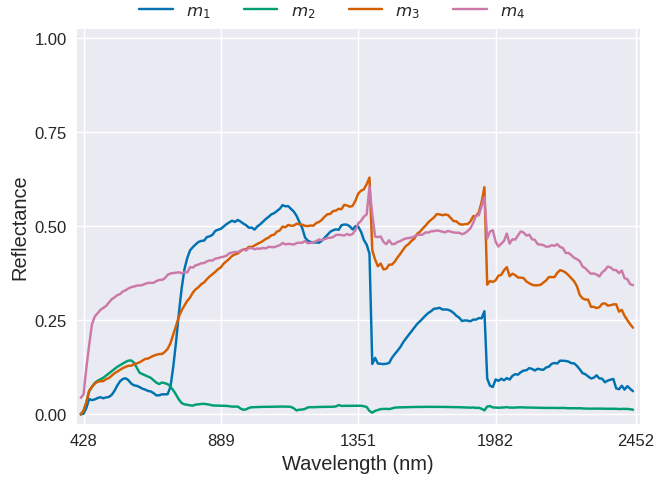

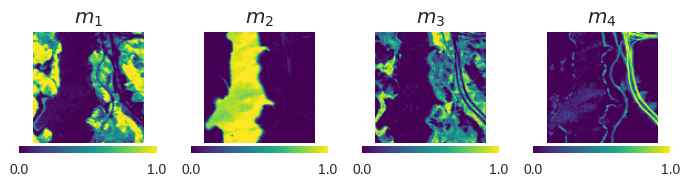

In [3]:
from utils import plot_endmembers, show_abundance
fig = plot_endmembers(dataset.endmembers(), wv, ticks_range=(0, 1), n_ticks=5)
plt.show(fig)
fig.savefig(os.path.join(result_path, 'imgs/M_ref.pdf'), bbox_inches='tight')

fig = show_abundance(dataset.abundance())
plt.show(fig)
fig.savefig(os.path.join(result_path, 'imgs/A_ref.png'), dpi=300, bbox_inches='tight')

In [4]:
from HySpecLab.metrics import sad

def sort_endmember(endmembers, gt):
    sad_result = sad(endmembers, gt)
    e_idx = torch.argmin(sad_result, dim=0) # Index for reordering the ground truth
    return e_idx, sad_result

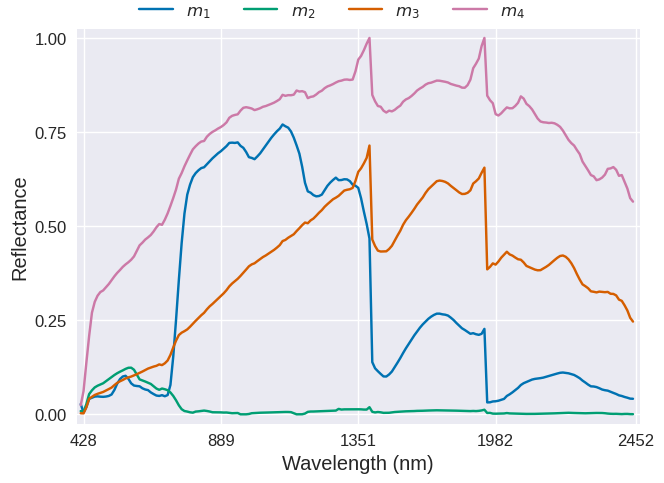

In [5]:
from HySpecLab.eea import VCA

n_endmembers = dataset.n_endmembers
   
vca = VCA(n_endmembers, snr_input=-1, random_state=25)
vca.fit(dataset.X.numpy())
endmembers = torch.from_numpy(vca.endmembers()).float()
e_idx, sad_result = sort_endmember(endmembers, dataset.endmembers())

vca_endmember_init = endmembers[e_idx]
vca_logit_endmember_init = torch.log((vca_endmember_init + 1e-12) / ((1-vca_endmember_init) + 1e-12))

fig = plot_endmembers(vca_endmember_init, wv, ticks_range=(0, 1))
plt.show(fig)

fig.savefig(os.path.join(result_path, 'imgs/M_vca.pdf'), bbox_inches='tight')

[0 1 2 3]


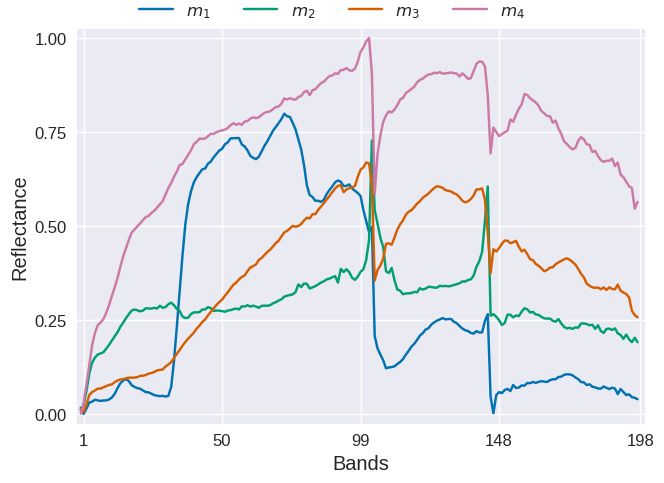

In [6]:
from pysptools import eea

ee = eea.ATGP()
endmember = torch.from_numpy(ee.extract(dataset.image(), n_endmembers)).float()

e_idx, sad_result = sort_endmember(endmember, dataset.endmembers())
atgp_endmember_init = endmember[e_idx]
atgp_logit_endmember_init = torch.log((atgp_endmember_init + 1e-12) / ((1-atgp_endmember_init) + 1e-12))
e_idx, _ = sort_endmember(endmember, dataset.endmembers())
print(np.unique(e_idx))

fig = plot_endmembers(atgp_endmember_init, ticks_range=(0, 1))
plt.show(fig)
fig.savefig(os.path.join(result_path, 'imgs/M_atgp.pdf'), bbox_inches='tight')

In [7]:
sad_result =sad(atgp_endmember_init, dataset.endmembers())
print(np.diag(sad_result).mean())

0.32292482


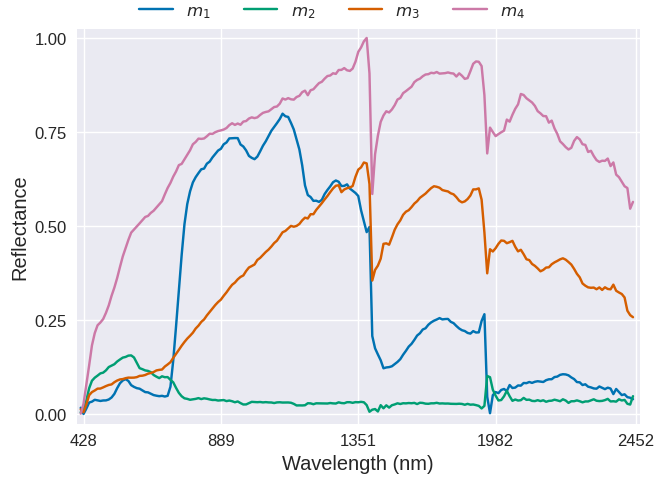

In [8]:
from utils import plot_endmembers
from pysptools import eea
n_endmembers = dataset.n_endmembers

ee = eea.NFINDR()
endmember = torch.from_numpy(ee.extract(dataset.image(), n_endmembers)).float()

e_idx, _ = sort_endmember(endmember, dataset.endmembers())
nfindr_endmember_init = endmember[e_idx]
nfindr_logit_endmember_init = torch.log((nfindr_endmember_init + 1e-12) / ((1-vca_endmember_init) + 1e-12))

fig = plot_endmembers(nfindr_endmember_init, wv, ticks_range=(0, 1))
plt.show(fig)
fig.savefig(os.path.join(result_path, 'imgs/M_nfindr.pdf'), bbox_inches='tight')

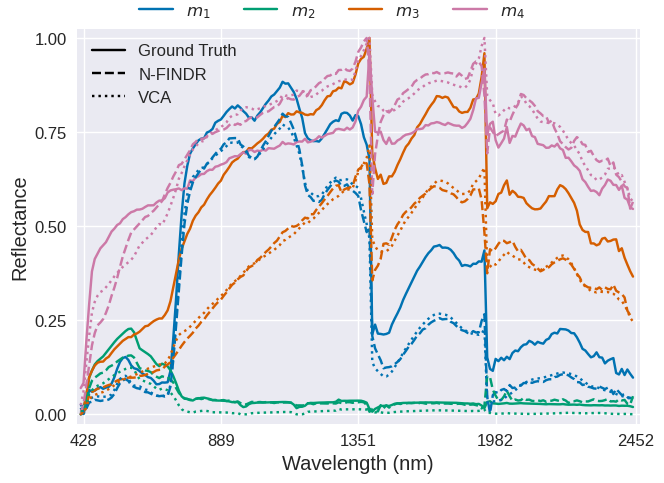

In [9]:
fig = plot_endmembers(dataset.endmembers() / dataset.endmembers().max(), wv, ticks_range=(0, 1), endmember_estimation=[nfindr_endmember_init, vca_endmember_init], ee_labels=['Ground Truth', 'N-FINDR', 'VCA'])
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'imgs/M_estimation.pdf'), bbox_inches='tight')

In [10]:
# endmember_init_method = 'nfindr'
# endmember_init = nfindr_endmember_init
# logit_endmember_init = nfindr_logit_endmember_init

endmember_init_method = 'vca'
endmember_init = vca_endmember_init
logit_endmember_init = vca_logit_endmember_init

# Training

In [36]:
from utils import train 
from HySpecLab.unmixing import ContrastiveUnmixing

n_bands = dataset.n_bands
model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init)
# train(model, n_endmembers, dataset, n_batchs=50, n_epochs=50, lr=1e-3, simplex_weight=5e-3)
train(model, n_endmembers, dataset, n_batchs=50, n_epochs=50, lr=1e-3, similarity_weight=1, simplex_weight=1e-2)

100%|██████████| 50/50 [00:24<00:00,  2.02epoch/s, tls=0.0552]


# Save model

In [37]:
# torch.save(model.state_dict(), os.path.join(result_path, 'clhu/weights/clhu.pth'))

# Testing model

In [12]:
from HySpecLab.unmixing import ContrastiveUnmixing

# # load model
model = ContrastiveUnmixing(dataset.n_bands, dataset.n_endmembers)

model.load_state_dict(torch.load(os.path.join(result_path, 'clhu/weights/clhu.pth')))
model = model.eval()

In [13]:
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss
from HySpecLab.metrics import UnmixingLoss, NormalizedEntropy

criterion = UnmixingLoss()
entropy_reg  = NormalizedEntropy(S=dataset.n_endmembers)
volume_reg = SimplexVolumeLoss(dataset[:], dataset.n_endmembers)
similarity_reg = SimilarityLoss(dataset.n_endmembers, temperature=.1, reduction='mean')

In [14]:
from torch import sigmoid 
_X = dataset.X

model.eval()
model = model.cpu()
reconstruc = model(_X)
with torch.no_grad():
    print(criterion(reconstruc, _X).cpu(), entropy_reg(model.A).cpu(), volume_reg(sigmoid(model.ebk)).cpu(),
         similarity_reg(model.ebk).cpu())

tensor(0.0398) tensor(0.5596) tensor(95.1378) tensor(0.0024)


In [15]:
volume_reg(endmember_init), similarity_reg(logit_endmember_init)

(tensor(203.2034), tensor(0.0168))

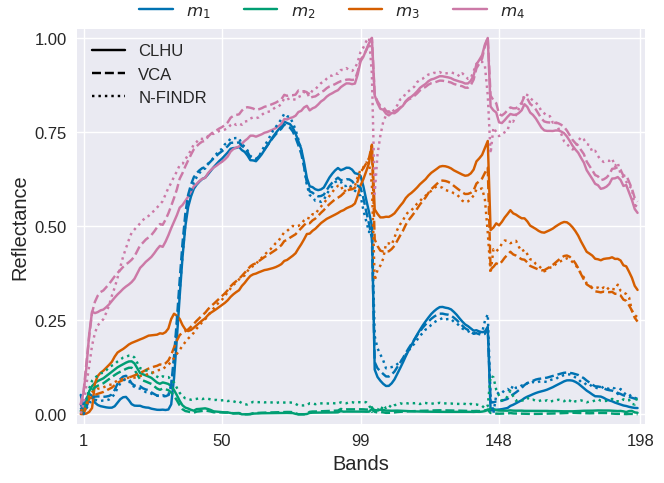

In [16]:
ebk = torch.sigmoid(model.ebk).detach().cpu()
if endmember_init_method == 'vca':
    label = 'VCA'
else:
    label = 'N-FINDR'
fig = plot_endmembers(ebk, ticks_range=(0, 1), endmember_estimation=[endmember_init, nfindr_endmember_init], ee_labels=['CLHU',label, 'N-FINDR'])
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'clhu/imgs/M_clhu.pdf'), bbox_inches='tight')

# fig = plot_endmembers(ebk, ticks_range=(0, 1))
# plt.show(fig)
# fig.savefig(os.path.join(result_path, 'clhu/imgs/M_clhu_2.pdf'), bbox_inches='tight')

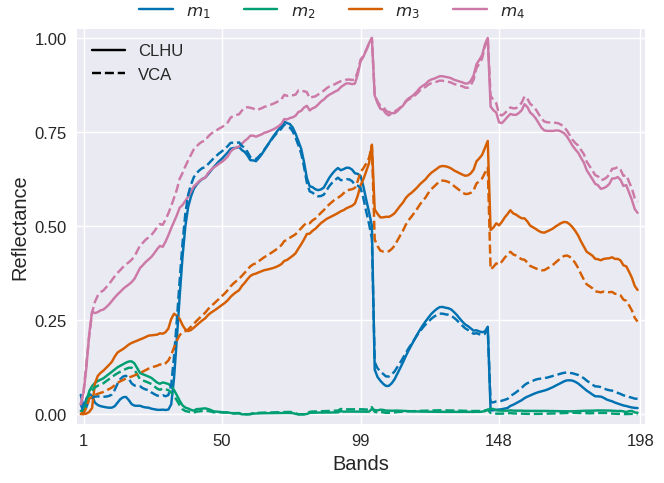

In [17]:
fig = plot_endmembers(ebk, ticks_range=(0, 1), endmember_estimation=[endmember_init], ee_labels=['CLHU',label])
plt.show(fig)


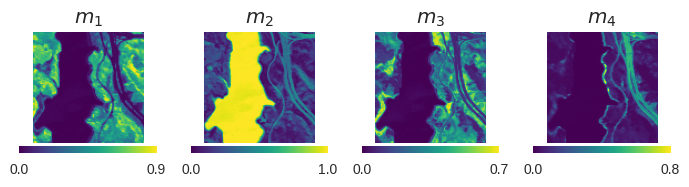

In [18]:
from torch.nn.functional import softmax
test = softmax(model.A.detach(), dim=1).cpu().numpy().reshape(dataset.n_row, dataset.n_col, -1)

from matplotlib import pyplot as plt

def show_abundance(A, transpose=True, labels:list = None, figsize:tuple=(7,5)):
    '''
        Show abundance maps.

        Parameters
        ----------
            A : 3-D array, shape (n_rows, n_cols, n_endmembers)
                Abundance maps.
            labels : list, optional
                Labels for endmembers. Default is None.
            figsize : tuple, optional
                Figure size. Default is (7,5).
    '''
    _, _, n_endmembers = A.shape

    if labels is None:
        labels = list(map(lambda x: r'$m_{{{}}}$'.format(x), range(1, n_endmembers+1)))
        
    ticks_formatter = plt.FormatStrFormatter('%.1f')
    fig = plt.figure(figsize=(7,5))
    for i in range(n_endmembers):
        data = A[:,:,i].T if transpose else A[:,:,i]
        plt.subplot(3,4,i+1)
        plt.imshow(data, cmap='viridis')
        plt.axis('off')
        plt.title(labels[i], fontsize='x-large')
        cb = plt.colorbar(format=ticks_formatter, ticks=[data.min() + 1e-3, data.max() - 1e-3],
                         orientation='horizontal', fraction=0.1, pad=0.03)

    plt.tight_layout()
    return fig

fig = show_abundance(test)
plt.show(fig)

# fig.savefig(os.path.join(result_path, 'clhu/imgs/A_clhu_estimation.png'), dpi=300, bbox_inches='tight')

In [20]:
X_true = dataset.A @ dataset.endmembers()
X_hat = model(dataset.X).detach().cpu()
A_hat = torch.softmax(model.A.detach().cpu(), dim=1)
M_hat = sigmoid(model.ebk.detach().cpu())

real_M_hat = model(M_hat).detach()

import pandas as pd
df = pd.DataFrame(columns=['Method', 'RMSE_X', 'RMSE_A', 'SAD_M'])
df['Method'] = ['CLHU']
df['RMSE_X'] = [rmse(X_true, X_hat, dim=None).numpy()]
df['RMSE_A'] = [rmse(dataset.A, A_hat, dim=None).numpy()]

# sad_result = sad(M_hat, dataset.endmembers()).numpy()
sad_result = sad(real_M_hat, dataset.endmembers()).numpy()
df['SAD_M'] = np.diagonal(sad_result).mean()

# df.to_csv(os.path.join(result_path, 'clhu/metrics.csv'), index=False)
df

,Method,RMSE_X,RMSE_A,SAD_M
0,CLHU,0.046890337,0.16285369,0.105494


tensor(1.5540e-13, grad_fn=<MinBackward1>) tensor(1., grad_fn=<MaxBackward1>)


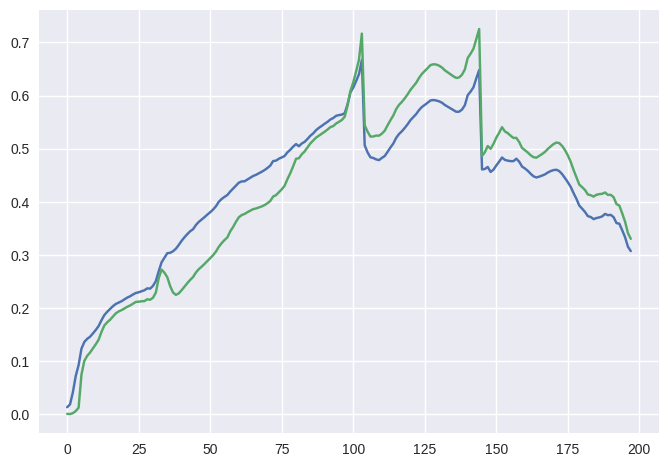

/tmp/ipykernel_12100/2033548742.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax(model.A)


tensor([[0.8469, 0.0810, 0.0503, 0.0217],
        [0.0110, 0.9768, 0.0092, 0.0029],
        [0.0847, 0.1484, 0.5116, 0.2554],
        [0.0677, 0.0479, 0.1121, 0.7724]], grad_fn=<SoftmaxBackward0>)

In [55]:
# model.ebk = sigmoid(model.ebk)
x_test = sigmoid(model.ebk)
m = model.ebk.detach()
model.eval()
print(x_test.min(), x_test.max())
encoder, projection = model.encoder, model.projection
from torch.nn.functional import normalize, softmax

def __similarity(X: torch.Tensor, ebk, temperature=1e-2) -> torch.Tensor:
        '''
            Cosine similarity between input and endmember bank.

            Parameters
            ----------
                x: torch.Tensor, shape=(batch_size, n_bands)
                    input tensor.
                
                temperature: float, default=1e-1
                    temperature parameter for contrastive learning.
                
        '''
        bs, n_bands = X.shape
        X = normalize(X, dim=1)

        normalize_ebk = normalize(ebk.detach(), dim=1).expand(bs, -1, -1)
        cos = torch.bmm(X.view(bs, 1, n_bands), torch.transpose(normalize_ebk, 1, 2)).squeeze()
        # return (1 - torch.pow(cos, 2))/temperature
        # return (torch.pow(cos, 2))/temperature
        return torch.log(torch.pow(cos, 2))

# y = projection(encoder(x_test))
# print(softmax(__similarity(y, m, temperature=.1).detach(), dim=1))

test = model(x_test)

plt.plot(test[2].detach().numpy())
plt.plot(x_test[2].detach().numpy())
plt.show()

softmax(model.A)

# ...

In [47]:
from torch import sigmoid
def test(model, dataset):
    X = dataset.X
    model.eval()
    model = model.cpu()
    
    X_true = dataset.A @ dataset.endmembers()
    with torch.no_grad():
        X_hat = model(dataset.X)
        A_hat = torch.softmax(model.A, dim=1)
        M_hat = sigmoid(model.ebk) 
    
    rmse_x = rmse(X_true, X_hat, dim=None).numpy()      
    rmse_a = rmse(dataset.A, A_hat, dim=None).numpy()
    sad_m = np.diagonal(sad(M_hat, dataset.endmembers()).numpy()).mean()
    return rmse_x.item(), rmse_a.item(), sad_m

In [48]:
from utils import train 
from HySpecLab.unmixing import ContrastiveUnmixing

n_bands = dataset.n_bands

batch_rmse_x = []
batch_rmse_a = []
batch_sad_m = []
for i in range(10):
    model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init)
    train(model, n_endmembers, dataset, n_batchs=50, n_epochs=50, lr=1e-3, similarity_weight=1, simplex_weight=1e-2)

    rmse_x, rmse_a, sad_m = test(model, dataset)
    batch_rmse_x.append(rmse_x)
    batch_rmse_a.append(rmse_a)
    batch_sad_m.append(sad_m)

    print(rmse_x, rmse_a, sad_m)

  0%|          | 0/50 [00:00<?, ?epoch/s, tls=-1.0000]

100%|██████████| 50/50 [00:17<00:00,  2.85epoch/s, tls=0.0550]


0.0438113808631897 0.16461175680160522 0.18540528


100%|██████████| 50/50 [00:14<00:00,  3.41epoch/s, tls=0.0563]


0.04555213451385498 0.16880740225315094 0.18488707


100%|██████████| 50/50 [00:20<00:00,  2.45epoch/s, tls=0.0574]


0.04539140686392784 0.15922631323337555 0.18437049


100%|██████████| 50/50 [00:20<00:00,  2.47epoch/s, tls=0.0568]


0.045916277915239334 0.16619762778282166 0.18418425


100%|██████████| 50/50 [00:19<00:00,  2.59epoch/s, tls=0.0544]


0.04614045470952988 0.1669457107782364 0.18565197


100%|██████████| 50/50 [00:19<00:00,  2.60epoch/s, tls=0.0541]


0.045950956642627716 0.16276606917381287 0.18370086


100%|██████████| 50/50 [00:19<00:00,  2.56epoch/s, tls=0.0556]


0.04549877345561981 0.16285571455955505 0.18558657


100%|██████████| 50/50 [00:20<00:00,  2.48epoch/s, tls=0.0556]


0.04530900716781616 0.16730578243732452 0.18349841


100%|██████████| 50/50 [00:18<00:00,  2.65epoch/s, tls=0.0547]


0.045800112187862396 0.16490894556045532 0.18439275


100%|██████████| 50/50 [00:18<00:00,  2.66epoch/s, tls=0.0557]

0.044693950563669205 0.1652490794658661 0.18304706


In [52]:
# generate dataframe
import pandas as pd
df = pd.DataFrame(columns=['RMSE_X', 'RMSE_A', 'SAD_M'])
df['RMSE_X'] = batch_rmse_x
df['RMSE_A'] = batch_rmse_a
df['SAD_M'] = batch_sad_m

# extract mean and std
df['RMSE_X'].mean(), df['RMSE_X'].std(), df['RMSE_A'].mean(), df['RMSE_A'].std(), df['SAD_M'].mean(), df['SAD_M'].std()

(0.045406445488333703,
 0.0006945434004583469,
 0.16488744020462037,
 0.002749773331400041,
 0.18447247,
 0.0009037134586833417)

In [53]:
df.to_csv(os.path.join(result_path, 'clhu/metrics_{}_batch.csv'.format(endmember_init_method)), index=False)

In [54]:
os.path.join(result_path, 'clhu/metrics_{}_batch.csv'.format(endmember_init_method))

'/media/abian/Extreme SSD/Thesis/CLHU/results/jasperRidge/clhu/metrics_vca_batch.csv'

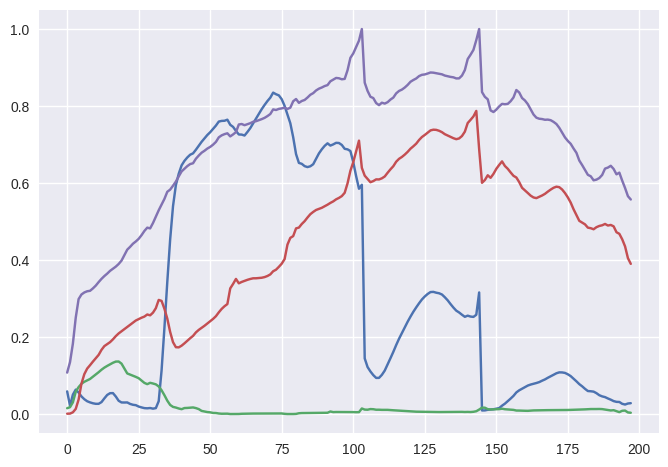

In [27]:
plt.plot(sigmoid(model.ebk).T.detach().cpu().numpy())
plt.show()

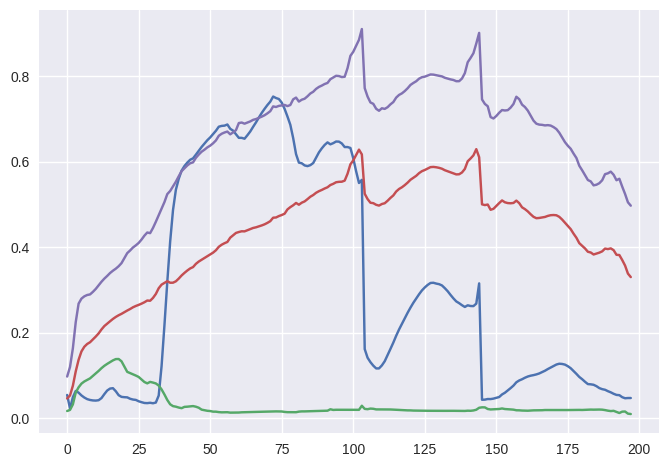

0.10977579

In [35]:
plt.plot(test.T.detach().cpu().numpy())
plt.show()

sad_m = np.diagonal(sad(test, dataset.endmembers()).detach().numpy()).mean()
sad_m

In [46]:
from torch.nn.functional import normalize   
M = logit_endmember_init
M_norm = normalize(M, dim=1)

sim_matrix = torch.mm(M_norm, M_norm.T) / .1

logit = torch.log((sim_matrix).softmax(dim=1))
lo2 = (sim_matrix).log_softmax(dim=1)

sim_matrix, torch.isclose(logit, lo2)


(tensor([[10.0000,  4.1333,  6.4940, -1.2102],
         [ 4.1333, 10.0000,  3.1977, -3.8441],
         [ 6.4940,  3.1977, 10.0000,  1.3009],
         [-1.2102, -3.8441,  1.3009, 10.0000]]),
 tensor([[ True,  True,  True,  True],
         [ True,  True,  True,  True],
         [ True,  True,  True,  True],
         [ True,  True,  True, False]]))

In [53]:
M_2 = M.clone()

M_2[0] = M_2[2]
M_norm = normalize(M_2, dim=1)

sim_matrix = torch.mm(M_norm, M_norm.T) / .1

logit = torch.log((sim_matrix).softmax(dim=1))
lo2 = (sim_matrix).log_softmax(dim=1)

sim_matrix, torch.isclose(logit, lo2)

# (sim_matrix).softmax(dim=1)

(tensor([[10.0000,  3.1977, 10.0000,  1.3009],
         [ 3.1977, 10.0000,  3.1977, -3.8441],
         [10.0000,  3.1977, 10.0000,  1.3009],
         [ 1.3009, -3.8441,  1.3009, 10.0000]]),
 tensor([[True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True]]))